In [94]:
#prepare the hamiltonian
from openfermion.chem import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermionpyscf import run_pyscf
dist = 0.9  # the unit of distance between two atoms is angstroms.
geometry = [['H', [0.0, 0.0, 0.0]], ['H', [0.0, 0.0, 1.0 * dist]]]
basis = "sto-3g"
multiplicity =1
charge = 0
description ='H_2'
molecule = MolecularData(geometry, basis, multiplicity, charge, description)
molecule = run_pyscf(molecule, run_scf=1, run_fci=1)
n_qubit = molecule.n_qubits
n_electron = molecule.n_electrons
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)
str(jw_hamiltonian)

'(-0.25905412221337215+0j) [] +\n(-0.04764292343981624+0j) [X0 X1 Y2 Y3] +\n(0.04764292343981624+0j) [X0 Y1 Y2 X3] +\n(0.04764292343981624+0j) [Y0 X1 X2 Y3] +\n(-0.04764292343981624+0j) [Y0 Y1 X2 X3] +\n(0.14907478844731487+0j) [Z0] +\n(0.1611381637816487+0j) [Z0 Z1] +\n(0.11162723403394151+0j) [Z0 Z2] +\n(0.15927015747375775+0j) [Z0 Z3] +\n(0.14907478844731498+0j) [Z1] +\n(0.15927015747375775+0j) [Z1 Z2] +\n(0.11162723403394151+0j) [Z1 Z3] +\n(-0.16071249108067312+0j) [Z2] +\n(0.16737125948304113+0j) [Z2 Z3] +\n(-0.16071249108067312+0j) [Z3]'

In [71]:
pauli_ham={'I': -0.25905412221337215, 'X0X1Y2Y3': -0.04764292343981624, 'X0Y1Y2X3': 0.04764292343981624, 'Y0X1X2Y3': 0.04764292343981624, 'Y0Y1X2X3': -0.04764292343981624, 'Z0': 0.14907478844731487, 'Z0Z1': 0.1611381637816487, 'Z0Z2': 0.11162723403394151, 'Z0Z3': 0.15927015747375775, 'Z1': 0.14907478844731498, 'Z1Z2': 0.15927015747375775, 'Z1Z3': 0.11162723403394151, 'Z2': -0.16071249108067312, 'Z2Z3': 0.16737125948304113, 'Z3': -0.16071249108067312}
def separate_pauli_operators(pauli_ham):
    separated_pauli_ham = {}
    for key, value in pauli_ham.items():
        new_key = ""
        for i in range(len(key)):
            new_key += key[i]
            if i % 2 == 1 and i != len(key) - 1:
                new_key += " "
        separated_pauli_ham[new_key] = value
    return separated_pauli_ham
pauli_ham=separate_pauli_operators(pauli_ham)

In [60]:
#prepare the ansatz circuit according to the hardware efficient ansatz circuit
from mindquantum import Circuit,RX,RY,X
depth = n_qubit
def ansatz_circuit(n_qubit, depth, theta_list):
    circ=Circuit()
    for d in range(depth):
        for i in range(n_qubit):
            circ+=RX(theta_list[2*i+2*n_qubit*d]).on(i)
            circ+=RY(theta_list[2*i+1+2*n_qubit*d]).on(i)
        for i in range(n_qubit//2):
            circ+=X(2*i,2*i+1)
        for i in range(n_qubit//2-1):
            circ+=X(2*i+1, 2*i+2)
    for i in range(n_qubit):
        circ+=RX(theta_list[2*i+2*n_qubit*depth]).on(i)
        circ+=RY(theta_list[2*i+1+2*n_qubit*depth]).on(i)
    return circ
# circ.svg()

In [85]:
from mindquantum import Circuit,Simulator
from mindquantum.core.operators import QubitOperator,Hamiltonian
def cost(theta_list,pauli_ham,n_qubit,depth):
    sim = Simulator("mqvector", n_qubit)
    circ=ansatz_circuit(n_qubit, depth, theta_list)
    sim.apply_circuit(circ)
    expectation=0
    for pauli,coeff in pauli_ham.items():
        if pauli=='I':
            expectation+=coeff
        else:
            ham= Hamiltonian(QubitOperator(pauli))
            expectation+=sim.get_expectation(ham).real*coeff
    return expectation

In [91]:
import numpy as np
from scipy.optimize import minimize
cost_history = []
init_theta_list = np.random.random(2*n_qubit*(depth+1))*1e-1
cost_history.append(cost(init_theta_list,pauli_ham,n_qubit,depth))
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}
opt = minimize(cost,init_theta_list,args=(pauli_ham, n_qubit, depth),method=method,callback=lambda x: cost_history.append(cost(x,pauli_ham,n_qubit,depth)))

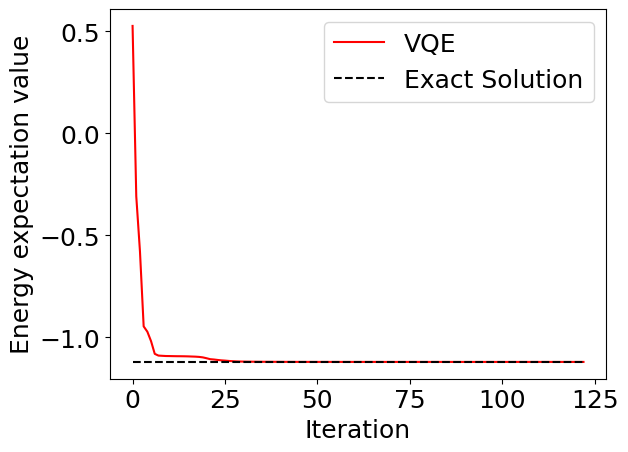

In [93]:
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="VQE")
plt.plot(range(len(cost_history)), [molecule.fci_energy]*len(cost_history), linestyle="dashed", color="black", label="Exact Solution")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()